In [2]:
# Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob as glob
import librosa as lr
from scipy import signal
import soundfile as sf
from scipy import stats
import scipy

In [3]:
from google.colab import files

uploaded  = files.upload()

Saving pno-cs.mp3 to pno-cs.mp3


In [4]:
audio, sfreq = lr.load('pno-cs.mp3')      $ Reading a musical signal using librosa library

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [5]:
# Creating a white gaussian noise 

time = np.arange(0,len(audio)) / sfreq

V_n =  np.random.normal(0,0.1,len(audio))

In [6]:
# This step creates two AR(1) process gaussian noise. The first one will be used to corrupt the original signal and the second one will be used as reference signal.

V1_n = np.zeros(len(audio))
V2_n = np.zeros(len(audio))


for i in range(len(audio)):
  V1_n[i] = 0.6*V_n[i-1] + V_n[i]
  V2_n[i] = 0.8*V_n[i-1] + V_n[i]

In [7]:
noisy_signal = audio + V1_n       # Adding the noise signal to original musical signal

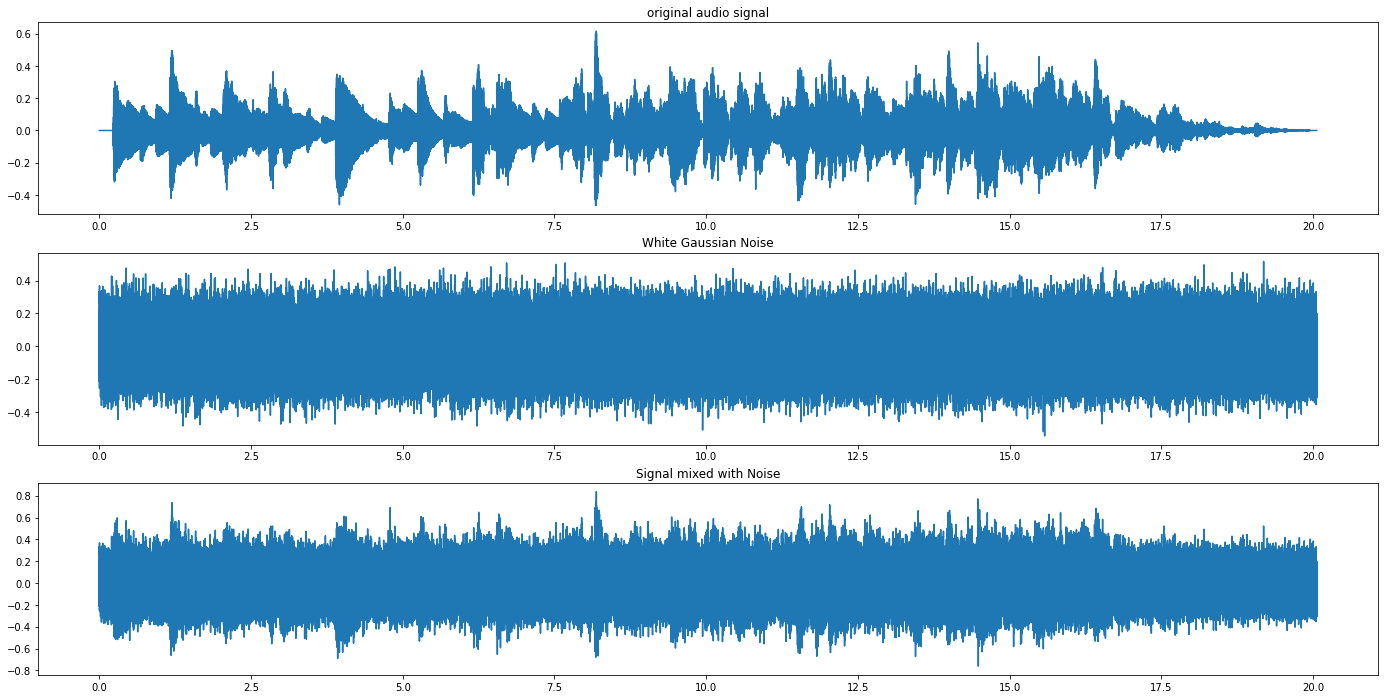

In [9]:
# Plotting the result

plt.figure(figsize=(24,12))
plt.subplot(311)
plt.plot(time,audio)
plt.title('original audio signal')

plt.subplot(312)
plt.plot(time,V1_n)
plt.title('White Gaussian Noise')

plt.subplot(313)
plt.plot(time,noisy_signal)
plt.title('Signal mixed with Noise')

plt.show()

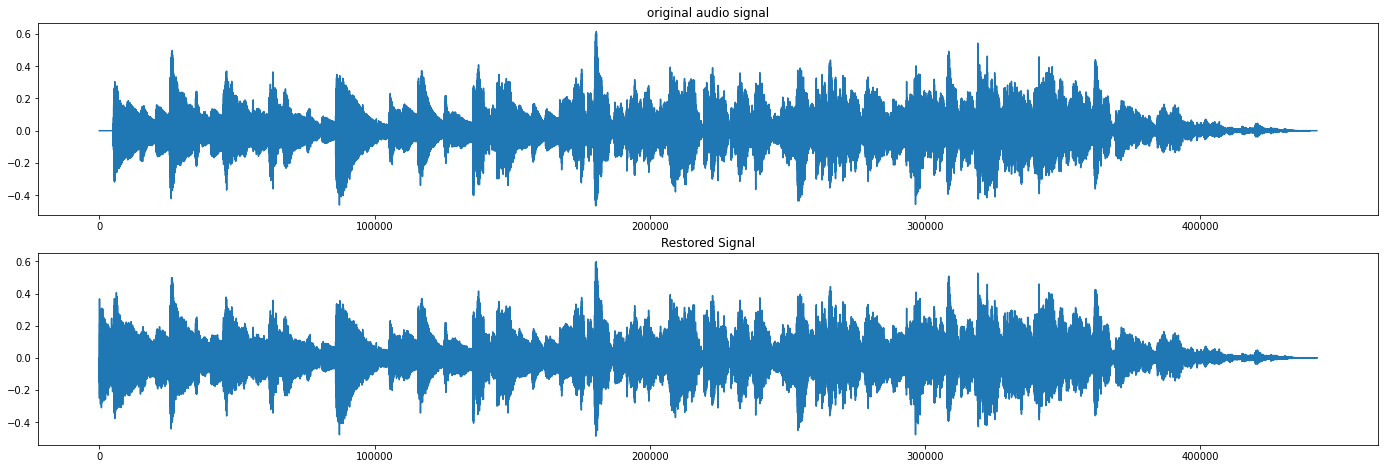

In [12]:
# Noise reduction using LMS Algorithm
restored_LMS = LMS_algorithm(noisy_signal,V2_n)

plt.figure(figsize=(24,12))
plt.subplot(311)
plt.plot(audio)
plt.title('original audio signal')

plt.subplot(312)
plt.plot(restored_LMS)
plt.title('Restored Signal')


plt.show()

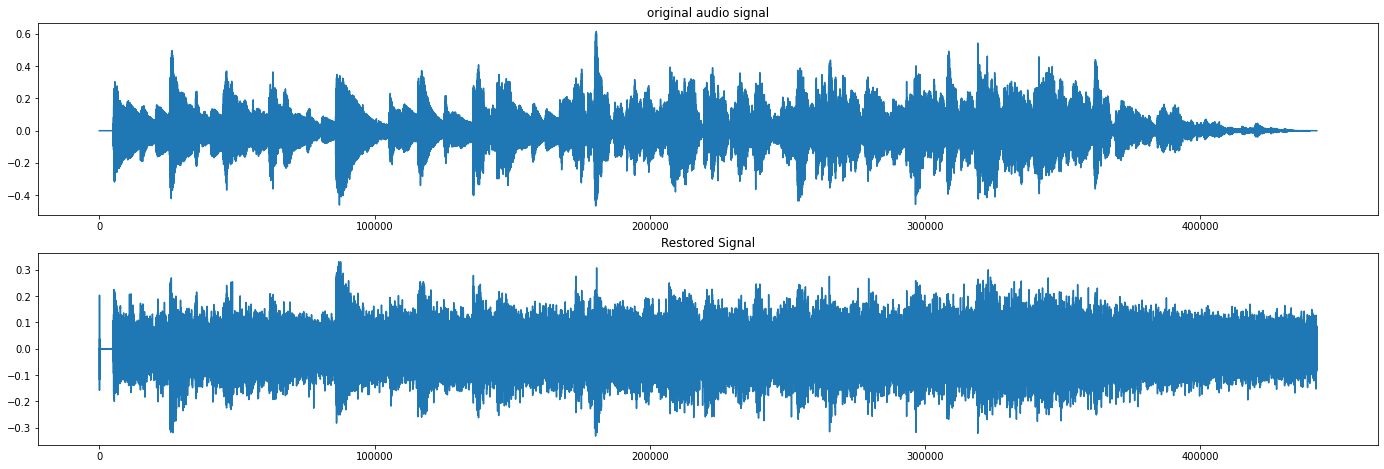

In [34]:
# Noise reduction using RLS Algorithm
restored_RLS = RLS_algorithm(noisy_signal,V2_n)[0]

plt.figure(figsize=(24,12))
plt.subplot(311)
plt.plot(audio)
plt.title('original audio signal')

plt.subplot(312)
plt.plot(restored_RLS)
plt.title('Restored Signal')


plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  
No handles with labels found to put in legend.


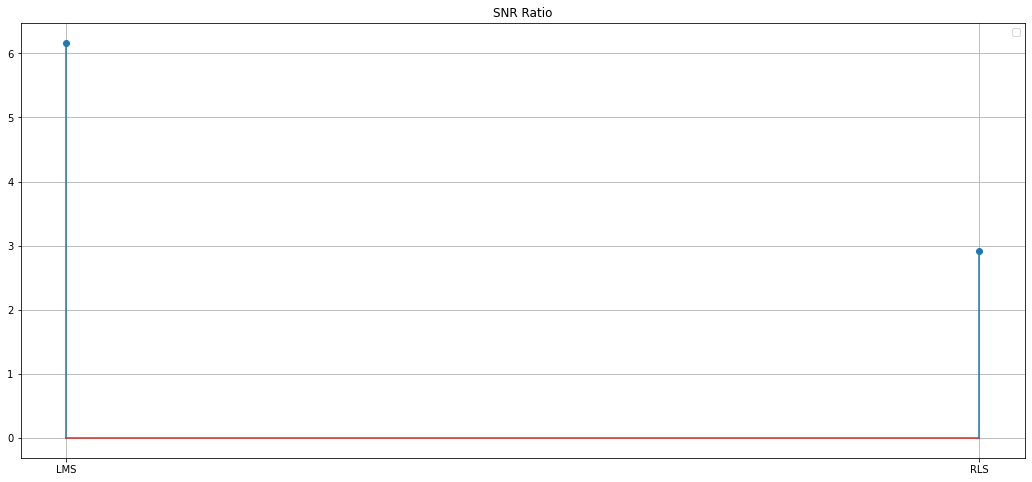

In [32]:
# Signal to Noise Ratio

SNR_LMS = np.log(np.sqrt(np.mean(audio**2)) / np.sqrt(np.mean(audio-restored_LMS)**2))
SNR_RLS = np.log(np.sqrt(np.mean(audio**2)) / np.sqrt(np.mean(audio-restored_RLS)**2))

xlabel = ['LMS','RLS']
plt.figure(figsize=(18,8))
plt.stem(xlabel,[SNR_LMS,SNR_RLS])
plt.grid()
plt.title('SNR Ratio')
plt.legend()
plt.show()

In [10]:
# Function for LMS Algorithm

def LMS_algorithm(noisy_signal,ref_signal):

  N = 51
  h = np.zeros(N)
  u = 0.01
  d_hat = np.zeros(len(noisy_signal))
  e = np.zeros(len(noisy_signal))

  for i in range(N+1,len(noisy_signal)):
    d_hat[i] = np.dot(np.transpose(h[0:]),ref_signal[i:i-N:-1])
    e[i] = noisy_signal[i] - d_hat[i]
    h[0:N] = h[0:N] + u*e[i]*ref_signal[i:i-N:-1]

  return e

In [33]:
# Function for RLS Algorithm

def RLS_algorithm(noisy_signal,ref_Signal):
  
  M = 51
  N = len(noisy_signal)
  h = np.zeros(M)
  delta = 0.01
  lamb = 1
  P = np.eye(M,M)/delta
  e = np.zeros(N)
  dhat = np.zeros(N)
  
  for i in range(M+1,N):
    dn = ref_Signal[i]
    yn = noisy_signal[i:i-M:-1]
    dhat[i] = np.dot(h,yn)
    e[i] = dn - dhat[i]
    temp = lamb + np.dot(np.dot(np.transpose(yn),P),yn)
    kn = (np.dot(P,yn))/temp
    h = h + kn*e[i]
    P = (P - (np.outer(kn,np.dot(np.transpose(yn),P))))/lamb
 
  return e,dhat

In [ ]:
# Noise Reduction using Kalman Filter

# Dividing into 80 ms frames with 10 ms overlap
begin = 1
frame_len = int(0.08*sfreq)
overlap = int(0.01*sfreq)
total_segment = int(np.ceil(len(noisy_signal)/(frame_len-overlap)))
segment = np.zeros((total_segment,frame_len))
zseq = np.zeros((total_segment,frame_len))

for i in range(total_segment):
  segment[i,0:frame_len] = noisy_signal[begin:begin+frame_len]
  zseq[i,0:frame_len] = audio[begin:begin+frame_len]
  begin = int((frame_len - overlap)*i + 1)

segment[total_segment-1,1:len(noisy_signal)-begin+1] = noisy_signal[begin:len(noisy_signal)]
zseq[total_segment-1,1:len(audio)-begin+1] = audio[begin:len(audio)]
  
clean_audio = np.zeros((total_segment,frame_len))
clean_audio2 = np.zeros(len(noisy_signal))

order = np.ones((total_segment,1),dtype = np.uint8)*15

# Calculating Measurement Noise variance R
noise_covariance = np.zeros((1,frame_len))
spec_flat = np.zeros((1,frame_len))
def xcorr(x,y):
  corr = signal.correlate(x, y, mode="full")
  lags = np.arange(-len(corr)//2+1,len(corr)//2+1)


  return lags, corr

for k in range(0,total_segment):
  [lags,c] = xcorr(segment[k,:],segment[k,:])
  psd = np.fft.fftshift(abs(np.fft.fft(c)))
  psd = psd[np.round(len(psd)//2):]
  freq_1 = (sfreq * np.arange(len(c)//2))/len(c)
  c_index = np.where(lags==0)[0][0]
  c = c[c_index:len(c)]
  lags = lags[c_index:len(lags)]
  f_2k = np.where(np.logical_and(freq_1>=100,freq_1<=2000))
  psd_2k = psd[f_2k]
  spec_flat[0][k] = stats.gmean(psd_2k)/np.mean(psd_2k)
  
normal_flatness = spec_flat / max(spec_flat)
thre_flat = 0.707

for k in range(1,frame_len):
  if(normal_flatness[0][k]>=thre_flat):
    noise_covariance[0][k] = np.var(segment[k,:])

R = max(noise_covariance[0])

J1 = np.zeros((1,10))
J2 = np.zeros((1,10))
num_q = np.zeros((1,10))


for m in range(3):
  snr_1 = 0
  snr_2 = 0
  u = 0
  Q_arr = np.zeros((1,total_segment))

  for i in range(total_segment-1):
    X_temp = noisy_signal[0:order[i][0]].T
    P = np.zeros((frame_len,order[i][0],order[i][0]))
    t1 = np.zeros((order[i][0],order[i][0]))
    H = np.concatenate((np.zeros(order[i][0]-1),np.array([1])))
    G = H.T

    # First Iteration of Kalman Filter
    A = lr.lpc(segment[i,:],order[i][0])
    fil_cf = np.hstack([[0], -1 * A[1:]])
    segment_filter = scipy.signal.lfilter(fil_cf, [1], segment[i,:])
    A_e = segment[1,:] -segment_filter
    Q1 = np.var(A_e)
    temp_A = np.eye(order[i][0],order[i][0])
    PHI= np.vstack([temp_A[1:order[i][0],:],-1*np.flip(A[1:])])

    if(i==0):
      P[1,:,:] = np.dot(R,np.eye(order[i][0],order[i][0]))
    else:
      P[1,:,:] = Y[:,:]

    # Calculating optimum values of process noise variance Q
    q = 0
    for r in range(-5,4):
      Q0 = (10**r)*Q1
      t1[:,:] = P[1,:,:]
      Ak0 = np.dot(np.dot(PHI,t1),PHI.T)
      Ak1 = np.dot(H,np.dot(Ak0,H.T))
      Bk = np.dot(H,np.dot(Q0,H.T))
      J1[0][q] = R/(Ak1+Bk+R)
      J2[0][q] = Bk/(Ak1+Bk)
      num_q[0][q] = np.log(Bk)
      q = q+1

    Q_arr[0][u] = Q0
    u = u+1

    for p in range(len(segment[i,:])):
      X_new = np.dot(PHI,X_temp)
      t1[:,:] = P[p,:,:]
      P_new = np.dot(np.dot(PHI,t1),PHI.T) + np.dot(G,np.dot(Q0,G.T))
      K = np.dot(P_new,H.T) / (np.dot(H,np.dot(P_new,H.T))+R)
      t1 = np.dot((np.eye(order[i][0],order[i][0]) - np.dot(K,H)),P_new)
      P[p,:,:] = t1[:,:]
      e = segment[i,p] - np.dot(H,X_new)
      X = X_new + K*e
      clean_audio[i,p] = X.reshape(-1)[-1]
      
    if(i<total_segment-1):
      t2 = np.zeros((order[i][0],order[i][0]))
      t2[:,:] = P[p-1,:,:]
      Y = adjustDimensions(t2,order[i+1][0])

    # Second Iteration of Kalman Filter
    A = lr.lpc(clean_audio[i,:],order[i][0])
    PHI= np.vstack([temp_A[1:order[i][0],:],-1*np.flip(A[1:])])
    X = clean_audio[i,0:order[i][0]].T

    if i==0:
      P0 = np.dot(R,np.eye(order[i][0],order[i][0]))
    else:
      P0 = Z

    for p in range(len(segment[i,:])):
      X_new = np.dot(PHI,X_temp)
      P_new = np.dot(np.dot(PHI,P0),PHI.T) + np.dot(G,np.dot(Q0,G.T))
      K = np.dot(P_new,H.T) / (np.dot(H,np.dot(P_new,H.T))+R)
      P0 = np.dot((np.eye(order[i][0],order[i][0]) - np.dot(K,H)),P_new)
      e = segment[i,p] - np.dot(H,X_new)
      X = X_new + K*e
      clean_audio[i,p] = X.reshape(-1)[-1]
      
    if(i<total_segment-1):
      Z = adjustDimensions(P0,order[i+1][0])

    # Calculating Segmental SNR
    snr_1 = snr_1 + np.log(np.sqrt(np.mean(zseq**2)) / np.sqrt(np.mean(zseq-segment)**2))
    snr_2 = snr_2 + np.log(np.sqrt(np.mean(zseq**2)) / np.sqrt(np.mean(zseq-clean_audio)**2))

    # Overlap Add
    clean_audio2[0:frame_len] = clean_audio[0,:]
    start = frame_len+1
    for i in range(1,total_segment-3):
      clean_audio2[start:start+frame_len-overlap] = clean_audio[i,overlap:]
      start = start + frame_len - overlap

    clean_audio2[start:len(noisy_signal)-2*1544] = clean_audio[total_segment-1,len(noisy_signal)-start-2*1544]
    clean_audio2 = clean_audio2[1:len(noisy_signal)]

    # Normalizing
    noisy_signal = noisy_signal/(abs(1.2*max(noisy_signal)))
    audio = audio/(abs(1.2*max(audio)))
    clean_audio2 = clean_audio2/(abs(1.2*max(clean_audio2)))

In [35]:
def adjustDimensions(P,order):
  m = len(P[0])
  Y = np.zeros((order,order))
  if(order>m):
    newRow = np.zeros(order-m,m)
    newCol = np.zeros(order,order-m)
    temp = np.concatenate((P,newRow),axis=0)
    Y = np.concatenate((temp,newCol),axis=1)

  else:
    if(order==m):
      Y = P
    else:
      Y[:,:] = P[0:order,0:order]

  return Y